In [34]:
import os
import warnings
warnings.filterwarnings('ignore')
os.chdir('../../')

import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import loompy as lp

# 1. Load & Harmonize
- batch correct per sample

In [2]:
files = [f for f in os.listdir('tmp/seacell/') if f.endswith('_seacell.h5ad')]

In [3]:
adatas = [sc.read_h5ad(os.path.join('tmp/seacell/', f)) for f in files]

In [4]:
adata = sc.concat(adatas, join = 'outer')
adata

AnnData object with n_obs × n_vars = 15247 × 29437
    obs: 'tumor', 'tumor_purity', 'ncells_per_SEACell', 'author', 'donor_id', 'method', 'assay'
    layers: 'raw'

In [5]:
adata.raw = adata

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key = 'donor_id', n_top_genes = 3000, inplace=True)

In [7]:
sc.tl.pca(adata, use_highly_variable = True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

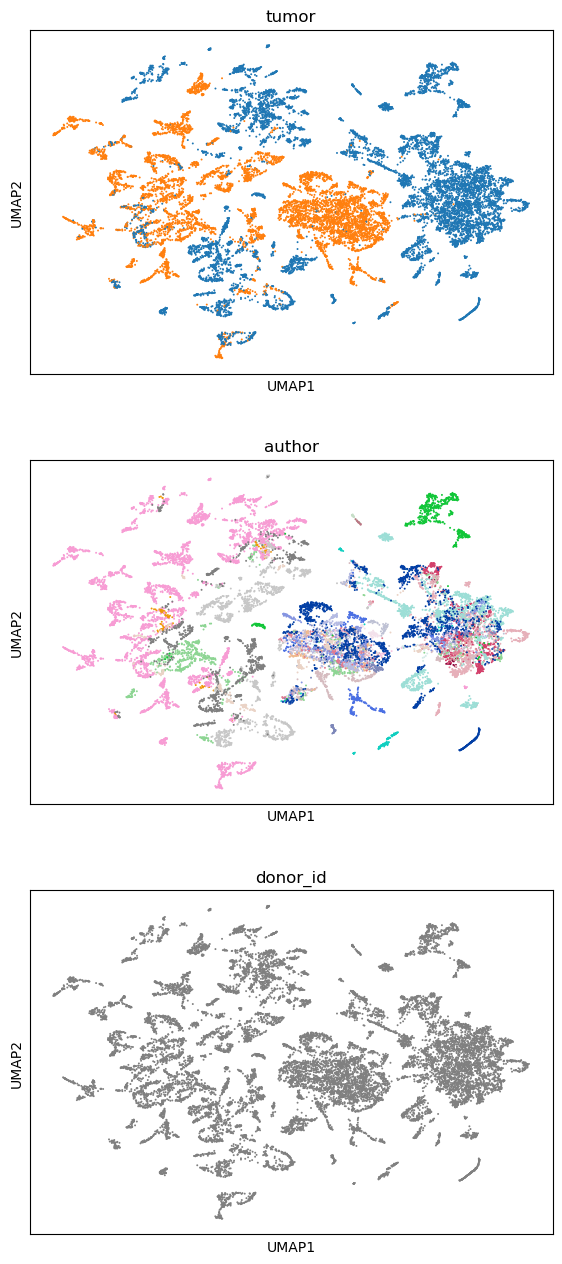

In [9]:
sc.pl.umap(adata, color = ['tumor', 'author', 'donor_id',], ncols = 1, legend_loc = None)

In [13]:
sc.external.pp.harmony_integrate(adata, key = 'donor_id', max_iter_harmony = 100)

2025-01-17 00:27:20,313 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-17 00:27:23,335 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-17 00:27:23,416 - harmonypy - INFO - Iteration 1 of 100
2025-01-17 00:27:31,144 - harmonypy - INFO - Iteration 2 of 100
2025-01-17 00:27:38,318 - harmonypy - INFO - Iteration 3 of 100
2025-01-17 00:27:45,509 - harmonypy - INFO - Iteration 4 of 100
2025-01-17 00:27:54,865 - harmonypy - INFO - Iteration 5 of 100
2025-01-17 00:28:03,665 - harmonypy - INFO - Iteration 6 of 100
2025-01-17 00:28:26,211 - harmonypy - INFO - Iteration 7 of 100
2025-01-17 00:28:33,508 - harmonypy - INFO - Iteration 8 of 100
2025-01-17 00:28:43,593 - harmonypy - INFO - Iteration 9 of 100
2025-01-17 00:28:52,364 - harmonypy - INFO - Iteration 10 of 100
2025-01-17 00:29:01,326 - harmonypy - INFO - Iteration 11 of 100
2025-01-17 00:29:12,228 - harmonypy - INFO - Iteration 12 of 100
2025-01-17 00:29:24,305 - harmonypy - INFO - Con

In [14]:
sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
sc.tl.umap(adata)

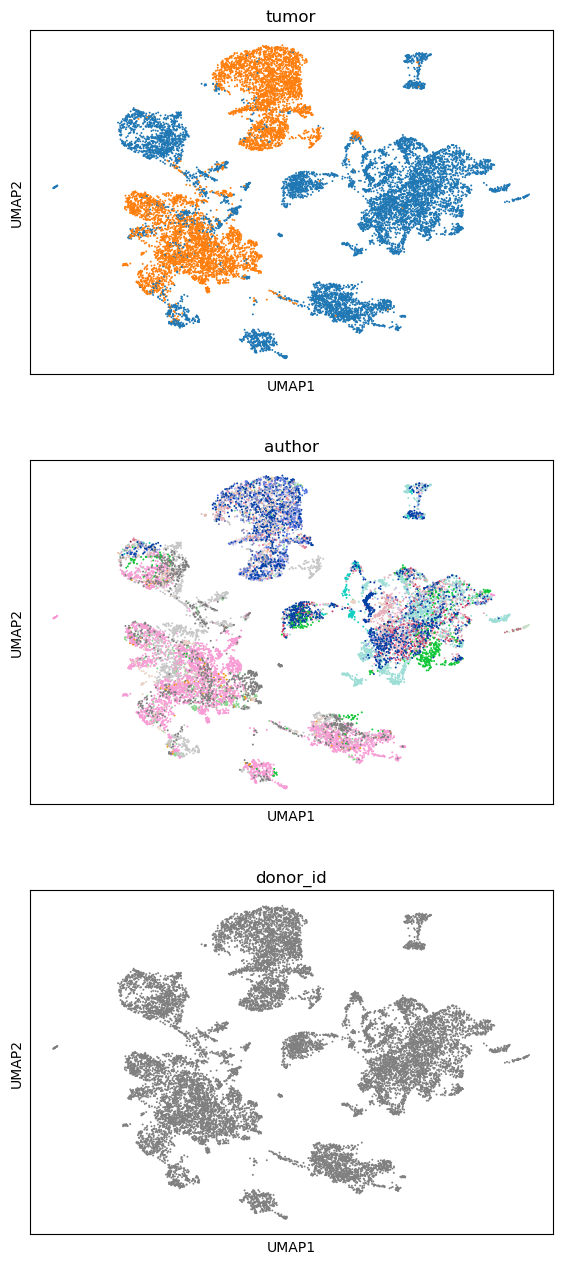

In [15]:
sc.pl.umap(adata, color = ['tumor', 'author', 'donor_id',], ncols = 1, legend_loc = None)

# 2. Prepare scenic
- normalize per cohort (author)

In [16]:
np.max(adata.X)

11.619255442938952

In [17]:
adata.X = adata.layers['raw'].copy()

In [18]:
np.max(adata.X)

3567165.0

In [19]:
def normalize_per_author(adata):
    bdata = adata.copy()
    sc.pp.normalize_total(bdata, target_sum=1e6)
    sc.pp.log1p(bdata)
    sc.pp.scale(bdata)
    return bdata

authors = adata.obs['author'].unique()
adatas = [adata[adata.obs['author'] == author] for author in authors]
adatas = [normalize_per_author(adata) for adata in adatas]

In [20]:
adata = sc.concat(adatas, join = 'outer')
adata

AnnData object with n_obs × n_vars = 15247 × 29437
    obs: 'tumor', 'tumor_purity', 'ncells_per_SEACell', 'author', 'donor_id', 'method', 'assay'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    layers: 'raw'

In [21]:
np.max(adata.X)

58.13544517354966

In [35]:
adata.write('tmp/pyscenic/seacell.h5ad')

In [38]:
def create_loom(adata, path):
    row = {"Gene": np.array(adata.var_names)}
    col = {"CellID": np.array(adata.obs_names)}
    matrix = adata.X.transpose()
    lp.create(path, matrix, row, col)
    
create_loom(adata, 'tmp/pyscenic/seacell.loom')

In [39]:
adata = sc.read_loom('tmp/pyscenic/seacell.loom')
adata

AnnData object with n_obs × n_vars = 15247 × 29437

In [41]:
tfs = [tf.strip() for tf in open('/home/jiehoonk/mnt/annotations/new/_tf.txt')]
print(len(tfs))
print(f"{np.sum(adata.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object")

1892
1708 out of 1892 TFs are found in the object
